# Machine Learning Project on Github Issues
+ Github Issue Classification
+ Predicting if Github Issue is a Bug,Enhancement,Question or Docs,etc.
+ Data Source
+ https://tickettagger.blob.core.windows.net/datasets/dataset-labels-top3-30k-real.txt
+ https://gist.githubusercontent.com/rafaelkallis/6aa281b00d73d77fc843bd34f8184854/raw/8c10ebf2fd6f937f8
+ https://github.com/dotnet/samples/tree/main/machine-learning/tutorials/GitHubIssueClassification/Data
+ Credits & Derivative Work
+ httpsBEE, Yang Song and Oscar Chaparro
+ Tim Moser, David Steiger, Christian Birchler, Lara Fried, Sebastiano Panichella, Rafael Kallis

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.dummy import DummyClassifier
import wget
import neattext.functions as nfx


In [78]:
# PATHs
CSV_PATH = r"Github-Issue-Classification\data\dataset-labels-top3-30k-real.txt"
CLEAN_CSV_PATH = r"Github-Issue-Classification\data\github-issues-labels-top3-30k-real.csv"

In [4]:
# url = 'https://tickettagger.blob.core.windows.net/datasets/dataset-labels-top3-30k-real.txt'
# filename = wget.download(url)
# print(filename)

In [30]:
df = pd.read_csv(CSV_PATH, header=None)

In [31]:
df.head()

,0
0,__label__enhancement Exception handling # Desc...
1,__label__enhancement Subpasses in MSL and HLSL...
2,__label__enhancement Collect new discovered no...
3,__label__enhancement Lock property : several p...
4,__label__bug Return default location type labe...


## Text Cleaning
+ Extract the labels from the text
  - Originally in Fastext Format
  - _label_enchancement| bug| question

In [47]:
df = df[0].str.split(r'(__label__enhancement)|(__label__bug)|(__label__question)', expand=True)

In [66]:
enchance_df = df[df[1] == "__label__enhancement"][[1,4]]
bug_df = df[df[2] == "__label__bug"][[2,4]]
question_df = df[df[3] == "__label__question"][[3,4]]

In [70]:
col_names= ["label", "description"]
enchance_df.columns = col_names
bug_df.columns = col_names
question_df.columns = col_names

In [72]:
df = pd.concat([enchance_df, bug_df, question_df ])
df.reset_index(drop=True, inplace=True)
df.shape

(30000, 2)

In [82]:
df["label"] = df["label"].str.replace("__label__","")

In [83]:
df.head()

,label,description
0,enhancement,Exception handling # Description The methods...
1,enhancement,Subpasses in MSL and HLSL Sorry for all the i...
2,enhancement,Collect new discovered nodes Collect new adde...
3,enhancement,Lock property : several properties at once
4,enhancement,Randomize: remove sliders


In [84]:
df.to_csv(CLEAN_CSV_PATH, index=False)

## EDA

In [101]:
df.describe()

,label,description
count,30000,30000
unique,3,29123
top,bug,new github test https://test-company1.kayako.c...
freq,15286,14


In [102]:
df.isna().sum()

label          0
description    0
dtype: int64

In [92]:
df["label"].value_counts(normalize=True)

bug            0.509533
enhancement    0.406433
question       0.084033
Name: label, dtype: float64

<AxesSubplot:xlabel='label', ylabel='count'>

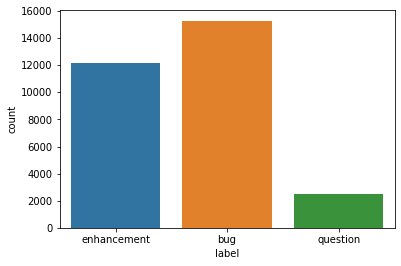

In [96]:
sns.countplot(x="label", data=df)

## Text Cleaning 

In [98]:
df["description"][0]

' Exception handling # Description  The methods that use try/catch blocks are quite limiting. Simply throw the exceptions and let users handle them. New idea: an exception handler wrapper class?    # Technical Information  | Information | Value |  |--|--|  | Operating System | Irrelevant |  |Architecture | Irrelevant |  | JavaEssentials Version| 1.2.2 Beta 1 |  '

In [100]:
df["description"]= df["description"].apply(lambda x: nfx.remove_stopwords(str(x).lower()) )

## Building our model using Pipeline approach

In [113]:
pipe_base = Pipeline(steps= [("cv",CountVectorizer()), ("dummy", DummyClassifier())] )
pipe_nb = Pipeline(steps= [("cv",CountVectorizer()), ("nb", MultinomialNB())] )
pipe_lr = Pipeline(steps= [("cv",CountVectorizer()), ("lr", LogisticRegression())] )
pipe_dt = Pipeline(steps= [("cv",CountVectorizer()), ("lr", DecisionTreeClassifier())] )


### Features & Labels i.e X & y

In [114]:
X = df["description"]
y = df["label"]

### Splitting the dataset

In [115]:
X_train,x_test,y_train,y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Base Model: Dummy

In [116]:
pipe_base.fit(X_train,y_train)

Pipeline(steps=[('cv', CountVectorizer()), ('dummy', DummyClassifier())])

In [118]:
# Accuracy
pipe_base.score(x_test, y_test)

0.5091111111111111

### Naive Bayes

In [120]:
pipe_nb.fit(X_train,y_train)

Pipeline(steps=[('cv', CountVectorizer()), ('nb', MultinomialNB())])

In [121]:
pipe_nb.score(x_test, y_test)

0.6584444444444445

In [131]:
y_pred = pipe_nb.predict(x_test)

In [132]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         bug       0.76      0.62      0.68      4582
 enhancement       0.59      0.81      0.69      3679
    question       0.39      0.10      0.16       739

    accuracy                           0.66      9000
   macro avg       0.58      0.51      0.51      9000
weighted avg       0.66      0.66      0.64      9000



### Decision Tree

In [122]:
pipe_dt.fit(X_train,y_train)

Pipeline(steps=[('cv', CountVectorizer()), ('lr', DecisionTreeClassifier())])

In [123]:
pipe_dt.score(x_test, y_test)

0.6702222222222223

In [128]:
y_pred = pipe_dt.predict(x_test)

In [129]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         bug       0.73      0.75      0.74      4582
 enhancement       0.69      0.66      0.67      3679
    question       0.24      0.26      0.25       739

    accuracy                           0.67      9000
   macro avg       0.55      0.55      0.55      9000
weighted avg       0.67      0.67      0.67      9000



## Logistic Regression

In [124]:
pipe_lr.fit(X_train,y_train)

C:\Users\Rohan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('cv', CountVectorizer()), ('lr', LogisticRegression())])

In [125]:
pipe_lr.score(x_test, y_test)

0.7323333333333333

In [126]:
y_pred = pipe_lr.predict(x_test)

In [127]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         bug       0.77      0.79      0.78      4582
 enhancement       0.73      0.76      0.74      3679
    question       0.39      0.26      0.31       739

    accuracy                           0.73      9000
   macro avg       0.63      0.60      0.61      9000
weighted avg       0.72      0.73      0.73      9000



## Saving the model

In [136]:
MODEL_DIR = r"Github-Issue-Classification\models"
import os
import joblib

In [138]:
def save_model(model, model_name):
    model_path = os.path.join(MODEL_DIR, model_name)
    model_file = open(model_path,"wb")
    joblib.dump(model, model_file)
    model_file.close()

In [141]:
save_model(pipe_nb,"github_issue_clf_nb.pkl")
save_model(pipe_lr,"github_issue_clf_lr.pkl")
save_model(pipe_dt,"github_issue_clf_dt.pkl")

## Make prediction

In [143]:
test_1 = "Lock property : several properties at once"
test_label = "enhancement"

In [147]:
print(pipe_nb.classes_)
print(pipe_nb.predict_proba([test_1]))
pipe_nb.predict([test_1])


['bug' 'enhancement' 'question']
[[0.09306899 0.89487336 0.01205765]]


array(['enhancement'], dtype='<U11')

In [148]:
print(pipe_lr.classes_)
print(pipe_lr.predict_proba([test_1]))
pipe_lr.predict([test_1])

['bug' 'enhancement' 'question']
[[0.43930402 0.4845223  0.07617369]]


array(['enhancement'], dtype=object)

In [150]:
print(pipe_dt.classes_)
print(pipe_dt.predict_proba([test_1]))
pipe_dt.predict([test_1])

['bug' 'enhancement' 'question']
[[0. 0. 1.]]


array(['question'], dtype=object)